<a href="https://colab.research.google.com/github/HaswanthVIT/BakeScape/blob/main/BakeScape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install diffusers transformers accelerate xformers
!pip install pandas opencv-python Pillow scikit-image matplotlib
!pip install gradio wandb imagehash


Looking in indexes: https://download.pytorch.org/whl/cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 9.0 MB/s eta 0:00:00


Create folders

In [ ]:
# Create clean folder structure
!mkdir -p bakescape/{src,configs}
!mkdir -p data/{raw,processed}
!mkdir -p outputs/{gen,logs,ckpts}
!touch bakescape/__init__.py


Extract dataset info

In [ ]:
!unzip -q cakes-dataset.zip -d data/raw/


unzip:  cannot find or open cakes-dataset.zip, cakes-dataset.zip.zip or cakes-dataset.zip.ZIP.


In [13]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


!pip install kaggle


In [ ]:
!pip install kaggle


In [14]:
!kaggle datasets download -d ishikanaik/cakes-dataset -p data/raw/


Dataset URL: https://www.kaggle.com/datasets/ishikanaik/cakes-dataset
License(s): unknown
 93% 198M/213M [00:03<00:00, 48.3MB/s] 
100% 213M/213M [00:03<00:00, 60.5MB/s]


In [15]:
!unzip -q data/raw/cakes-dataset.zip -d data/raw/


In [16]:
!find data/raw/cakes-dataset/ -type f -name "*.jpg" -exec cp {} data/raw/ \;


In [17]:
!ls -R data/raw | head -50


data/raw:
107_920 Cheesecake Stock Photos....jpg
10 Cheesecake Toppings.jpg
11 Of Mumbai_s Very Best Cheesecakes....jpg
20 places for cheesecake in metro Phoenix (1).jpg
20 places for cheesecake in metro Phoenix.jpg
22 Best vegan cheesecake recipes you... (1).jpg
22 Best vegan cheesecake recipes you....jpg
23 Healthy Cheesecake Recipes _ Eat....jpg
2 Ingredient Cheesecake (No Cream... (1).jpg
2 Ingredient Cheesecake (No Cream....jpg
3-Ingredient Souffle Cheesecake _Sweet... (1).jpg
3-Ingredient Souffle Cheesecake _Sweet... (2).jpg
3-Ingredient Souffle Cheesecake _Sweet... (3).jpg
3-Ingredient Souffle Cheesecake _Sweet....jpg
3-Step Mini Cheesecakes.jpg
40 To-Die-For Cheesecake Recipes... (1).jpg
40 To-Die-For Cheesecake Recipes... (2).jpg
40 To-Die-For Cheesecake Recipes... (3).jpg
40 To-Die-For Cheesecake Recipes... (4).jpg
40 To-Die-For Cheesecake Recipes....jpg
5-Minute Microwave Cheesecake Recipe by....jpg
65 Best Easy Cheesecake Recipes - How....jpg
6 Inch Cheesecake Recipe ┬╗ Hum

In [18]:
!ls data/raw | wc -l


2498


Create Index and EDA

In [19]:
!pip install imagehash


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 7.3 MB/s eta 0:00:00


In [20]:
import os
import cv2
import pandas as pd
import imagehash
from PIL import Image

raw_dir = "data/raw/"
files = [f for f in os.listdir(raw_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))]

records = []
for f in files:
    path = os.path.join(raw_dir, f)
    try:
        img = cv2.imread(path)
        h, w, c = img.shape
        # perceptual hash for duplicate check
        phash = str(imagehash.phash(Image.open(path)))
        records.append([f, w, h, c, phash])
    except:
        print("Corrupted:", f)

df = pd.DataFrame(records, columns=["filename","width","height","channels","phash"])
df.to_csv("data_index.csv", index=False)
df.head()


,filename,width,height,channels,phash
0,Philadelphia - Recipe - Fresh Berry....jpg,1000,1000,3,f184ce59b0669bca
1,Cheesecake Recipe - Preppy Kitchen.jpg,1024,537,3,fab5a1da8f2498a4
2,ia_100001012.jpg,310,163,3,bccdc1c48f9e1d18
3,The Cheesecake Factory Frozen Original....jpg,488,488,3,f42d49f28834bccd
4,The Best Vegan Cheesecake - Nora Cooks (1).jpg,667,1000,3,c3bf60823f49f087


In [21]:
import pandas as pd

df_index = pd.read_csv("data_index.csv")
display(df_index)

,filename,width,height,channels,phash
0,Philadelphia - Recipe - Fresh Berry....jpg,1000,1000,3,f184ce59b0669bca
1,Cheesecake Recipe - Preppy Kitchen.jpg,1024,537,3,fab5a1da8f2498a4
2,ia_100001012.jpg,310,163,3,bccdc1c48f9e1d18
3,The Cheesecake Factory Frozen Original....jpg,488,488,3,f42d49f28834bccd
4,The Best Vegan Cheesecake - Nora Cooks (1).jpg,667,1000,3,c3bf60823f49f087
...,...,...,...,...,...
2491,ia_100000870.jpg,225,225,3,afe086ec9c35b886
2492,ia_300000950.jpg,201,251,3,82a70397df82daa3
2493,ia_100000700.jpg,183,275,3,ff12923f3d524036
2494,ia_500000918.jpg,275,183,3,ce663931c3d863c6


Duplicate Check

In [22]:
dupes = df[df.duplicated("phash", keep=False)].sort_values("phash")
dupes


,filename,width,height,channels,phash
215,ia_300000687.jpg,225,225,3,80363f36294d75c7
873,ia_100000005407.jpg,700,700,3,80363f36294d75c7
1320,ia_300000702.jpg,275,183,3,81bfdbf209583c2c
859,ia_100000005402.jpg,1134,757,3,81bfdbf209583c2c
1745,ia_100000005352.jpg,2560,1439,3,83423e99e5eeec41
...,...,...,...,...,...
2290,ia_300000415.jpg,259,194,3,fec0954d1274db19
1402,ia_300000406.jpg,225,225,3,ff749160102f70af
545,ia_100000004959.jpg,1200,1200,3,ff749160102f70af
505,ia_300000465.jpg,190,266,3,ff82a1c0d44ec32f


Remove Duplicates

In [23]:
unique_df = df.drop_duplicates(subset="phash", keep="first")
print("After removing duplicates:", len(unique_df))

# Move only unique images into a new folder
import shutil

os.makedirs("data/unique", exist_ok=True)
for f in unique_df['filename']:
    src = os.path.join(raw_dir, f)
    dst = os.path.join("data/unique", f)
    shutil.copy(src, dst)


After removing duplicates: 2424


In [24]:
import os, shutil

raw_dir = "data/raw/"

# reload index if you already saved it
import pandas as pd
df = pd.read_csv("data_index.csv")

# drop duplicates
unique_df = df.drop_duplicates(subset="phash", keep="first")

# make folder
os.makedirs("data/unique", exist_ok=True)

# copy files
for f in unique_df['filename']:
    src = os.path.join(raw_dir, f)
    dst = os.path.join("data/unique", f)
    if os.path.exists(src):
        shutil.copy(src, dst)

print("Unique images copied:", len(os.listdir("data/unique/")))


Unique images copied: 2424


In [25]:
!ls data/unique | wc -l


2424


Summary Report

In [26]:
print("Cleaned dataset report")
print("======================")
print("Total images (after deduplication):", len(unique_df))
print("Unique perceptual hashes:", unique_df['phash'].nunique())
print("\nImage size distribution:")
print(unique_df[['width','height']].describe())


Cleaned dataset report
Total images (after deduplication): 2424
Unique perceptual hashes: 2424

Image size distribution:
             width       height
count  2424.000000  2424.000000
mean    467.242162   453.908828
std     566.017262   540.852522
min     100.000000   100.000000
25%     201.000000   194.000000
50%     259.000000   243.000000
75%     500.000000   410.250000
max    6625.000000  5617.000000


In [ ]:
unique_df.sample(5)


,filename,width,height,channels,phash
1563,ia_100000783.jpg,225,225,3,aaa49578c57ba2b1
33,ia_100000922.jpg,183,275,3,a88ac70db4e11bcf
1385,ia_500000510.jpg,183,275,3,b9e0cb86f98a7074
1540,Perfect Cheesecake - Broma Bakery.jpg,1600,2400,3,bf9cc861e046c3f8
2119,ia_100000686.jpg,225,225,3,be1e892b74d2834d


END OF SECTION 1




---



SECTION 2 : Detailed Auto-Captioning with BLIP-2

Install BLIP-2 Dependencies

In [ ]:
!pip install transformers accelerate timm
!pip install sentencepiece


Step 2. Import BLIP-2 Model

In [ ]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration
import torch
from PIL import Image
import os, json, pandas as pd


Load BLIP-2 (FP16 to save GPU memory):

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    torch_dtype=torch.float16
).to(device)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

Step 3. Define Schema Prompt

In [ ]:
schema_prompt = (
    "Describe this cake in detail using this format: "
    "[Shape] [Tier count] [Flavor/Base] cake with [Frosting/Icing] and [Toppings/Decoration]. "
    "Example: A round two-tier vanilla cake with pink buttercream frosting and strawberries on top."
)


Step 4. Generate Captions for All Cakes

In [32]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch, os, pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load BLIP captioning model
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained(
    "Salesforce/blip-image-captioning-base"
).to(device)

# Directories
unique_dir = "data/unique/"
files = [f for f in os.listdir(unique_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))]

# Controlled vocab
flavors = ["chocolate", "vanilla", "red velvet", "cheesecake", "pie"]
frostings = ["buttercream", "fondant", "whipped cream", "cream cheese"]
toppings = ["strawberries", "cherries", "berries", "sprinkles", "candles", "fruits"]
shapes = ["round", "square", "rectangular", "slice", "piece"]
tiers = ["single-tier", "two-tier", "three-tier"]

def enrich_caption(raw_caption):
    cap = raw_caption.lower()
    shape = next((s for s in shapes if s in cap), "round")
    tier = next((t for t in tiers if t in cap), "single-tier")
    flavor = next((f for f in flavors if f in cap), "vanilla")
    frosting = next((fr for fr in frostings if fr in cap), "buttercream")
    topping = next((t for t in toppings if t in cap), "no toppings")
    structured = f"A {shape} {tier} {flavor} cake with {frosting} and {topping}."
    return structured

# Captioning loop
all_caps = []
for i, f in enumerate(files):
    try:
        img = Image.open(os.path.join(unique_dir, f)).convert("RGB")
        inputs = processor(img, return_tensors="pt").to(device)
        out = model.generate(**inputs, max_new_tokens=40)
        raw_caption = processor.decode(out[0], skip_special_tokens=True)
        structured_caption = enrich_caption(raw_caption)

        all_caps.append({
            "filename": f,
            "raw_caption": raw_caption,
            "structured_caption": structured_caption
        })

        if i % 50 == 0:
            print(f"[{i}/{len(files)}] {f} → {raw_caption} → {structured_caption}")

    except Exception as e:
        print("Error with file:", f, e)

# Save results
df = pd.DataFrame(all_caps)
df.to_csv("captions_structured.csv", index=False)
df.to_json("captions_structured.json", orient="records", indent=2)
print("✅ Captions saved for", len(df), "images")


[0/2424] Philadelphia - Recipe - Fresh Berry....jpg → a white cake with berries and whipped cream → A round single-tier vanilla cake with whipped cream and berries.
[50/2424] ia_100000557.jpg → a piece of chocolate cake on a plate → A piece single-tier chocolate cake with buttercream and no toppings.
[100/2424] Red Velvet Cheesecake Cake - Recipe Girl (1).jpg → a red velvet cake with a slice taken out of it → A slice single-tier red velvet cake with buttercream and no toppings.
[150/2424] ia_500000698.jpg → a white cake with red velvet frosting → A round single-tier red velvet cake with buttercream and no toppings.
[200/2424] ia_100001131.jpg → a plate of chocolate cake with candy corn → A round single-tier chocolate cake with buttercream and no toppings.
[250/2424] ia_300000710.jpg → a blue plate with a piece of pie on it → A piece single-tier pie cake with buttercream and no toppings.
[300/2424] ia_100001165.jpg → a cake on a white plate → A round single-tier vanilla cake with butter

In [33]:
import pandas as pd
df = pd.read_csv("captions_structured.csv")
df.sample(10)  # random 10 captions


,filename,raw_caption,structured_caption
1161,ia_100001210.jpg,a piece of chocolate cake on a plate,A piece single-tier chocolate cake with butter...
2075,ia_300000810.jpg,a pie with a slice taken out of it,A slice single-tier pie cake with buttercream ...
777,ia_100001007.jpg,a chocolate cake with rass on top,A round single-tier chocolate cake with butter...
1072,Layered Chocolate Cheesecake - Just so....jpg,a slice of chocolate cheese pie on a white plate,A slice single-tier chocolate cake with butter...
1646,Strawberry Cheesecake Recipe _ Baked by....jpg,a slice of cheese cheese cheese cheese with st...,A slice single-tier vanilla cake with buttercr...
1003,ia_500000513.jpg,red velvet cake in a heart shape,A round single-tier red velvet cake with butte...
1490,ia_300000964.jpg,a pair of feet,A round single-tier vanilla cake with buttercr...
1037,ia_500000812.jpg,a white plate topped with mini red velvet dess...,A round single-tier red velvet cake with butte...
1126,ia_500001130.jpg,a red cake with a flower on top,A round single-tier vanilla cake with buttercr...
1986,ia_100000765.jpg,a white plate with a piece of cake on it,A piece single-tier pie cake with buttercream ...


Visual Verification

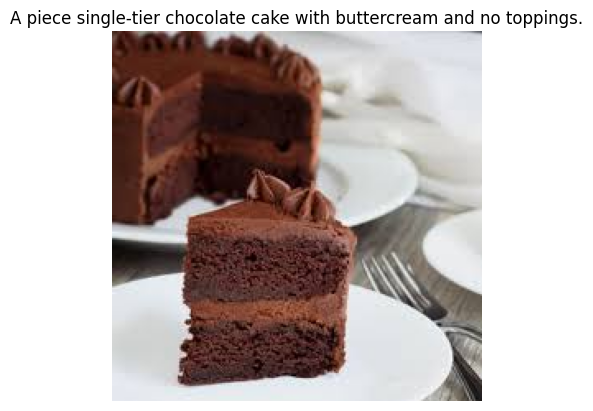

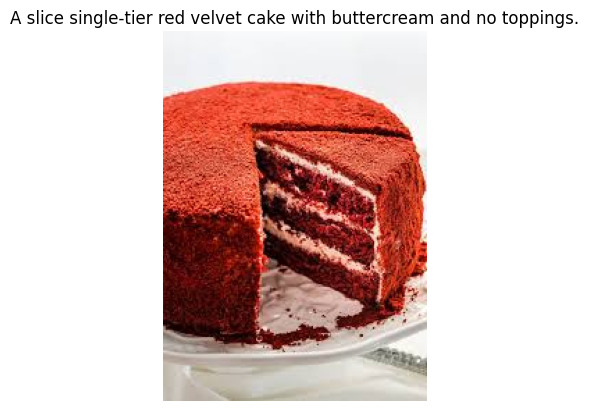

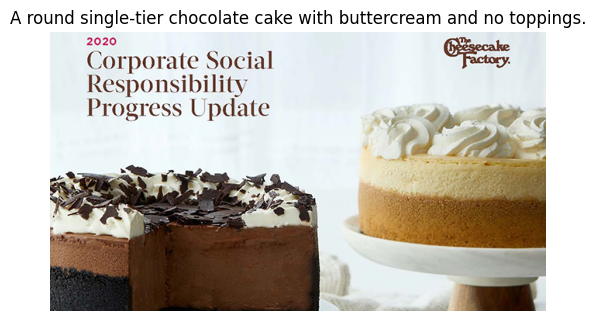

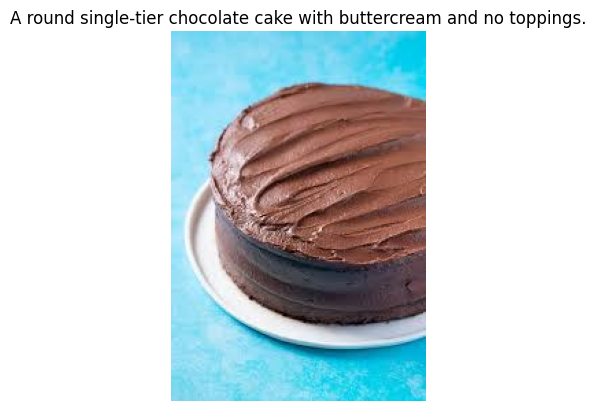

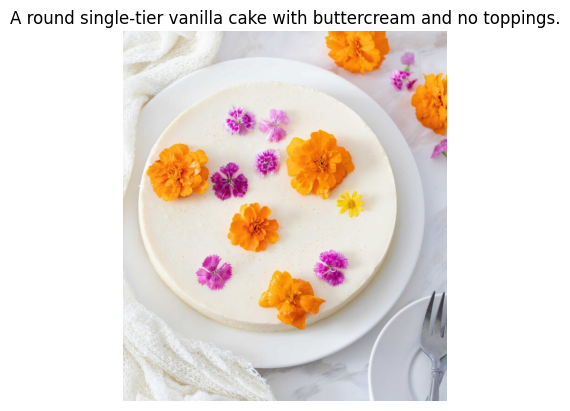

In [34]:
import matplotlib.pyplot as plt
import random
from PIL import Image

samples = random.sample(list(df.to_dict("records")), 5)

for s in samples:
    img = Image.open(os.path.join("data/unique", s["filename"]))
    plt.imshow(img)
    plt.axis("off")
    plt.title(s["structured_caption"])
    plt.show()


Keyword Coverage Check

In [35]:
print("Chocolate captions:", df['structured_caption'].str.contains("chocolate").sum())


Chocolate captions: 624


END OF SECTION 2



---



SECTION 3:

In [1]:
!jupyter nbconvert --ClearMetadataPreprocessor.enabled=True --to notebook --inplace your_notebook.ipynb


[NbConvertApp] WARNING | pattern 'your_notebook.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
 

In [2]:
!pip install nbstripout
!nbstripout --install


fatal: --local can only be used inside a git repository
Installation failed: not a git repository!
